# Zastoupení žen v Poslanecké sněmovně ČR

Notebook analyzuje zastoupení žen v PS ČR na základě dat z <a href="https://www.psp.cz/sqw/hp.sqw?k=1300" target="_blank" rel="nofollow noopener noreferrer">archivu PS ČR</a>. Součástí analýzy je extrapolace historických dat pomocí lineární regrese.

## Nastavení prostředí

Nastavení notebooku pro prostředí Google Colab a pro lokální běh.

In [1]:
# Specifické příkazy pro prostředí Google Colab
if 'google.colab' in str(get_ipython()):
        import os, sys
        os.chdir('/content')
        # Stažení knihovny
        ! ls parlamentikon || git clone "https://github.com/parlamentikon/parlamentikon.git" --branch main
        os.chdir('/content/parlamentikon/notebooks')

In [2]:
instalace_zavislosti = True
if instalace_zavislosti:
    ! pip install -r ../requirements.txt 1>/dev/null

In [3]:
instalace_knihovny = False
if instalace_knihovny:
    ! pip install ..  1>/dev/null
else:
    # Přidání cesty pro lokální import knihovny
    import sys, os
    sys.path.insert(0, os.path.abspath('..'))

## Import knihoven

In [20]:
from datetime import datetime, timedelta
import plotly.graph_objects as go
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.metrics import r2_score
import math

In [5]:
from parlamentikon.Hlasovani import Organy
from parlamentikon.PoslanciOsoby import Poslanci

## Nastavení parametrů

In [6]:
# Data se budou pokaždé znovu stahovat z achivu PS
stahni=True

## Načtení dat

In [7]:
# Načti tabulku Organy
vsechny_organy = Organy(volebni_obdobi=-1)

# Vyber z tabuky Organy data o jednotlivých sněmovnách a seřaď dle data začátku vzestupně
snemovny = vsechny_organy[vsechny_organy.nazev_typ_organ_cz == 'Parlament'].od_organ.dt.year.sort_values()

# Načti tabulku Poslanci
poslanci = {}
for i in snemovny:
    poslanci[i] = Poslanci(volebni_obdobi=i, stahni=stahni)

2021-09-26:20:18:25 INFO     [utility.py:21] Stahuji 'https://www.psp.cz/eknih/cdrom/opendata/poslanci.zip'.
2021-09-26:20:18:25 INFO     [utility.py:21] Stahuji 'https://www.psp.cz/eknih/cdrom/opendata/poslanci.zip'.
2021-09-26:20:18:26 WARNING  [Snemovna.py:149] While merging 'funkce' with 'typ_funkce': Dropping ['typ_organ_obecny__typ_funkce', 'id_typ_organ__typ_funkce', 'nazev_typ_organ_cz__typ_funkce', 'nazev_typ_organ_en__typ_funkce', 'typ_id_typ_organ__typ_funkce'] because of abundance.
2021-09-26:20:18:27 INFO     [utility.py:21] Stahuji 'https://www.psp.cz/eknih/cdrom/opendata/poslanci.zip'.
2021-09-26:20:18:28 WARNING  [Snemovna.py:149] While merging 'funkce' with 'typ_funkce': Dropping ['typ_organ_obecny__typ_funkce', 'id_typ_organ__typ_funkce', 'nazev_typ_organ_cz__typ_funkce', 'nazev_typ_organ_en__typ_funkce', 'typ_id_typ_organ__typ_funkce'] because of abundance.
2021-09-26:20:18:29 INFO     [utility.py:21] Stahuji 'https://www.psp.cz/eknih/cdrom/opendata/poslanci.zip'.
20

## Analýza historických dat

In [8]:
def pohlavi_dle_snemovny(snemovna, dalsi_snemovna=None):
    x = poslanci[snemovna]
    
    # Najdi datum konce vybrané sněmovny.
    last_do_parlament = vsechny_organy[vsechny_organy.id_organ == x.id_organ.iloc[0]].do_organ.iloc[0]
    # Poslanci nemohou mít mandát platný déle než do konce vybrané sněmovny. 
    x.do_parlament.mask(pd.to_datetime(x.do_parlament) > last_do_parlament, last_do_parlament, inplace=True) 
    
    if dalsi_snemovna == None:
        # Poslanci z poslední sněmovny nemají vyplněné "do". Nahradíme ho aktuálním datem.
        today_date = pd.to_datetime("now").tz_localize('Europe/Prague')
        x.do_parlament.mask(x.do_parlament.isna(), today_date, inplace=True) 
    else:
        # Najdi datum začátku další sněmovny.
        next_od_parlament = vsechny_organy[vsechny_organy.id_organ == poslanci[dalsi_snemovna].id_organ.iloc[0]].od_organ.iloc[0]
        # Poslanci nemohou mít platný mandát po začátku další sněmovny.
        x.do_parlament.mask(pd.to_datetime(x.do_parlament) > next_od_parlament, next_od_parlament, inplace=True) 
        #print(snemovna, dalsi_snemovna, x.do_parlament.sort_values().to_list()[-1], next_od_parlament, x[x.do_parlament > next_od_parlament])
       
    # Pro dny, ve kterých se mění složení poslanecké sněmovny, sečteme tyto změny vzhledem k pohlaví. 
    # Používáme nezávislé sčítače pro příchody a odchody.
    zeny_od = x[x.pohlavi == 'žena'].groupby(x.od_parlament.dt.date, dropna=False).size().to_frame('zeny_od').rename_axis(index={'od_parlament': 'datum'})
    zeny_do = x[x.pohlavi == 'žena'].groupby(x.do_parlament.dt.date, dropna=False).size().to_frame('zeny_do').rename_axis(index={'do_parlament': 'datum'})
    muzi_od = x[x.pohlavi == 'muž'].groupby(x.od_parlament.dt.date, dropna=False).size().to_frame('muzi_od').rename_axis(index={'od_parlament': 'datum'})
    muzi_do = x[x.pohlavi == 'muž'].groupby(x.do_parlament.dt.date,  dropna=False).size().to_frame('muzi_do').rename_axis(index={'do_parlament': 'datum'})

    # Spojíme sčítače příchodů a odchodů ze Sněmovny do jednoho framu.
    df = zeny_od.merge(muzi_od, how='outer', on='datum').merge(muzi_do, how='outer', on='datum').merge(zeny_do, how='outer', on='datum').sort_index()
    
    # Prázdné hodnoty, ktere zpravidla vznikly predchozi merge operaci, nahradíme nulami.
    df = df.fillna(0)
    
    # Fix pandas error which converts groupby sizes from int to float
    df['zeny_od'], df['zeny_do'] = df['zeny_od'].astype(int), df['zeny_do'].astype(int)
    df['muzi_od'], df['muzi_do'] = df['muzi_od'].astype(int), df['muzi_do'].astype(int)

    # Od sčítačů příchodů do sněmovny odečteme scítače odchodů.
    # Tím dostaneme pro každé datum, kdy se mění složení směnovny, bilanci počtu žen a mužů.
    df['zeny_cnt'] = df['zeny_od'].cumsum() - df['zeny_do'].cumsum()
    df['muzi_cnt'] = df['muzi_od'].cumsum() - df['muzi_do'].cumsum()
    
    # Hodnoty by se měly posčítat na 200 (počet poslanců).
    # Vzhledem k nejasné interpretaci 'do_parlament' a případné prodlevy před složením slibu nového poslance nebo poslankyně
    # to v několika málo případech není pravda, ale jen na krátkou dobu.
    df['check_cnt'] = df['zeny_cnt'] + df['muzi_cnt']
    
    # Na konci sněmovny se počet poslanců nuluje.
    # V tomto řádku je možné opravit zeny_cnt pomoci zeny_do (resp. muzi_cnt pomoci muzi_do).
    df_na_konci_snemovny = (df.check_cnt == 0) & ((df.zeny_do > 0) | (df.muzi_do > 0))
    df.zeny_cnt.mask(df_na_konci_snemovny, df.zeny_do, inplace=True) 
    df.muzi_cnt.mask(df_na_konci_snemovny, df.muzi_do, inplace=True) 

    # Spočítejme nyní poměry ...
    df['zeny_pct'] = 100 * df['zeny_cnt'] / (df['zeny_cnt'] + df['muzi_cnt'])
    df['muzi_pct'] = 100 * df['muzi_cnt'] / (df['zeny_cnt'] + df['muzi_cnt'])
    
    # Nastavme sněmovnu (na konstantní hodnotu).
    df['snemovna'] = snemovna
    
    df = df.sort_index()
    
    df = df[['zeny_pct', 'muzi_pct', 'zeny_cnt', 'muzi_cnt', 'snemovna', 'check_cnt']]
    return df

In [9]:
zastoupeni = []

l_snemovny = list(snemovny)
for idx, snemovna in enumerate(l_snemovny):
    if idx < len(l_snemovny) - 1:
        dalsi_snemovna = l_snemovny[idx + 1]
    else:
        dalsi_snemovna = None
        
    zastoupeni.append(pohlavi_dle_snemovny(snemovna, dalsi_snemovna))

zastoupeni_df = pd.concat(zastoupeni, join='outer')
zastoupeni_df.index = pd.to_datetime(zastoupeni_df.index)
zastoupeni_df.index.name = 'datum'

zastoupeni_df.head()

,zeny_pct,muzi_pct,zeny_cnt,muzi_cnt,snemovna,check_cnt
datum,,,,,,
1992-06-06,10.000000,90.000000,20,180,1992,200
1993-11-09,9.547739,90.452261,19,180,1992,199
1993-11-11,9.500000,90.500000,19,181,1992,200
1995-05-23,9.547739,90.452261,19,180,1992,199
1995-05-25,9.500000,90.500000,19,181,1992,200


In [10]:
# Kontrola smyslupnosti dat ... check_cnt by neměl být víc než 200.
# Bylo by dobré ověřit, že hodnoty menší než 200 jsou pouze krátkodobé fluktuace, ke kterým dochází během výměny poslanců v PS.

zastoupeni_df[(zastoupeni_df.check_cnt != 200)]

,zeny_pct,muzi_pct,zeny_cnt,muzi_cnt,snemovna,check_cnt
datum,,,,,,
1993-11-09,9.547739,90.452261,19,180,1992,199
1995-05-23,9.547739,90.452261,19,180,1992,199
1996-04-29,9.547739,90.452261,19,180,1992,199
1996-05-06,9.547739,90.452261,19,180,1992,199
1996-06-01,10.000000,90.000000,20,180,1992,0
1996-11-01,15.075377,84.924623,30,169,1996,199
1996-12-17,14.646465,85.353535,29,169,1996,198
1997-01-16,14.572864,85.427136,29,170,1996,199
1997-06-02,14.572864,85.427136,29,170,1996,199


## Extrapolace historických dat do budoucnosti

K extrapolaci zastoupení žen v PS do budoucnosti použijeme lineární regresi.

In [11]:
zastoupeni_df[pd.isna(zastoupeni_df.index)]
zastoupeni_df['days_from_start'] = (zastoupeni_df.index - zastoupeni_df.index[0]).days
zastoupeni_df.head()

,zeny_pct,muzi_pct,zeny_cnt,muzi_cnt,snemovna,check_cnt,days_from_start
datum,,,,,,,
1992-06-06,10.000000,90.000000,20,180,1992,200,0
1993-11-09,9.547739,90.452261,19,180,1992,199,521
1993-11-11,9.500000,90.500000,19,181,1992,200,523
1995-05-23,9.547739,90.452261,19,180,1992,199,1081
1995-05-25,9.500000,90.500000,19,181,1992,200,1083


In [12]:
x = zastoupeni_df['days_from_start'].values.reshape(-1, 1)
y = zastoupeni_df['zeny_pct'].values

# Použij model lineární regrese
model = linear_model.LinearRegression().fit(x, y)

# Vypiš základní informace o modelu
r_sq = model.score(x, y)
print('Intercept:', model.intercept_)
print('Slope:', model.coef_)
print('R^2 score:', r_sq)

Intercept: 11.529799506551512
Slope: [0.00111072]
R^2 score: 0.8373092006757612


In [34]:
# Vezmi všechny historické časové body vyjma posledního
x_historical = zastoupeni_df['days_from_start'].values[:-1]

# Spočítej, pro jaký bod se bude predikce rovnat 50%
last_x = math.ceil((50 - model.intercept_) / model.coef_)
rovne_zastoupeni_dt = (zastoupeni_df.index[0] + pd.DateOffset(days=last_x)).date()
print(f"Rovného zastoupní se dle predikce dosáhne: {rovne_zastoupeni_dt}.")

# Přidej dalších 70 bodů pro proložení lineární regresí do budoucnosti
x_extrapolated = np.ceil(np.linspace(zastoupeni_df['days_from_start'].max(), last_x, 70, endpoint=True)).reshape(1, -1)[0]

# Spoj historické body a body z budoucnosti
x_values = np.concatenate((x_historical, x_extrapolated))

# Uplatni predikci na historické body i body z budoucnosti
x_vector = [[v] for v in x_values]
y_pred = model.predict(x_vector)
y_pred[0:5]

Rovného zastoupní se dle predikce dosáhne: 2087-04-05.


array([11.52979951, 12.10848344, 12.11070487, 12.73048536, 12.73270679])

In [45]:
zastoupeni_extrapolace_df = pd.DataFrame(
    {"zeny_pct_extrapolace": y_pred},
    index=[zastoupeni_df.index[0] + pd.DateOffset(days=num_days) for num_days in x_values]
)
zastoupeni_extrapolace_df['rovne_zastoupeni_dt'] = rovne_zastoupeni_dt
zastoupeni_extrapolace_df.index.name = 'datum'
zastoupeni_extrapolace_df.head()

,zeny_pct_extrapolace,rovne_zastoupeni_dt
datum,,
1992-06-06,11.529800,2087-04-05
1993-11-09,12.108483,2087-04-05
1993-11-11,12.110705,2087-04-05
1995-05-23,12.730485,2087-04-05
1995-05-25,12.732707,2087-04-05


## Vizualizace

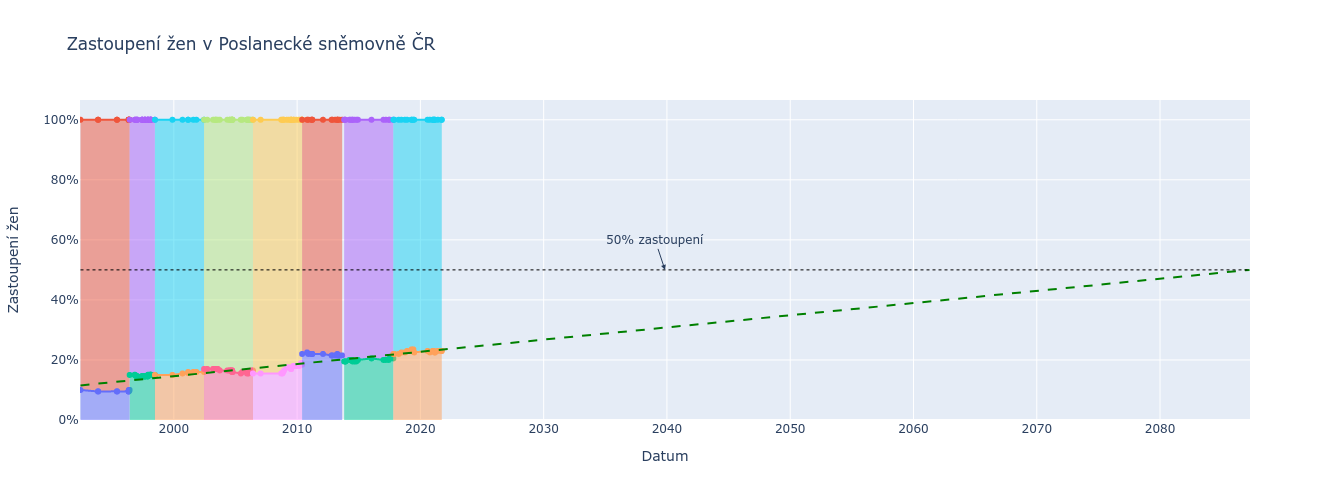

In [46]:
fig = go.Figure()

for snemovna in snemovny:
    df = pohlavi_dle_snemovny(snemovna)
    hovertemplate_zeny = f"Sněmovna: {snemovna}" +'<br>Datum: %{x|%d. %m. %Y}<br>Pohlaví: ženy<br>Počet: %{y}<extra></extra>'
    hovertemplate_muzi = f"Sněmovna: {snemovna}" +'<br>Datum: %{x|%d. %m. %Y}<br>Pohlaví: muži<br>Počet: %{y}<extra></extra>'
    
    # Ženy
    fig.add_trace(go.Scatter(
        x = df.index,
        y = df.zeny_pct,
        mode = 'markers+lines',
        hoverinfo = 'text',
        hovertemplate=hovertemplate_zeny,
        name=f"ženy ({snemovna})",
        stackgroup=snemovna
    ))
    
    # Muži
    fig.add_trace(go.Scatter(
        x = df.index,
        y = df.muzi_pct,
        name = f"muži ({snemovna})",
        hoverinfo = 'text',
        hovertemplate=hovertemplate_muzi,
        mode = 'markers+lines',
        #line = dict(shape='linear'),
        stackgroup=snemovna
    ))

    
fig.add_trace(go.Scatter(
        x = zastoupeni_extrapolace_df.index,
        y = zastoupeni_extrapolace_df.zeny_pct_extrapolace.round(2),
        name = f"ženy (extrapolace)",
        mode = 'lines',
        line = dict(color='green', width=2, dash='dash')
    ))

fig.add_shape(type="line",
    x0=zastoupeni_extrapolace_df.index[0], 
    y0=50,
    x1=zastoupeni_extrapolace_df.index[-1],
    y1=50,
    line=dict(color="black", width=1, dash='dot')
)

middle_x = zastoupeni_extrapolace_df.index[0] +  (zastoupeni_extrapolace_df.index[-1] -  zastoupeni_extrapolace_df.index[0]) / 2
fig.add_annotation(
    x=middle_x,
    y=50,
    text="50% zastoupení",
    arrowhead=2,
)


layout = go.Layout(
    title="Zastoupení žen v Poslanecké sněmovně ČR",    
    #plot_bgcolor="#FFFFFF",
    hovermode="x",
    xaxis=dict(title="Datum"),
    yaxis=dict(
        title="Zastoupení žen",
        tickvals = [0, 20, 40, 60, 80, 100],
        ticktext = ["0%", "20%", "40%", "60%", "80%", "100%"]
    )
)

fig.update_layout(layout)
fig.update_layout(showlegend=False,     autosize=False,
    width=1000,
    height=500,)
fig.show()


## Export dat

In [47]:
# Data bez extrapolace
! mkdir -p "../docs/data"
export_path = "../docs/data/zastoupeni_zen_v_PS_CR.csv"
zastoupeni_df[['zeny_pct', 'muzi_pct', 'zeny_cnt', 'muzi_cnt', 'snemovna']].to_csv(export_path)
! ls -l {export_path}

-rw-rw-r-- 1 borjana borjana 5176 zář 26 20:28 ../docs/data/zastoupeni_zen_v_PS_CR.csv


In [48]:
# Data s extrapolací
m = zastoupeni_df.merge(zastoupeni_extrapolace_df, how='outer', on='datum')
m = m.sort_index()
m.head()

! mkdir -p "../docs/data"
export_path = "../docs/data/extrapolace_zastoupeni_zen_v_PS_CR.csv"
m[['zeny_pct', 'muzi_pct', 'zeny_cnt', 'muzi_cnt', 'snemovna', 'zeny_pct_extrapolace', 'rovne_zastoupeni_dt']].to_csv(export_path)
! ls -l {export_path}

-rw-rw-r-- 1 borjana borjana 14052 zář 26 20:28 ../docs/data/extrapolace_zastoupeni_zen_v_PS_CR.csv


In [18]:
print(f"Poslední běh notebooku: {datetime.now().strftime('%d.%m.%Y %H:%M:%S')}.")

Poslední běh notebooku: 26.09.2021 20:18:43.
